In [6]:
# https://www.kaggle.com/c/titanic/discussion/5105
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import csv
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

In [7]:
test_data = pd.read_csv("data/test.csv")
df = pd.read_csv('data/train.csv')
gender_data = pd.read_csv('data/gender_submission.csv')

In [8]:
df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
df = df.drop(["Ticket", "Cabin"], axis=1)

In [15]:
fig = plt.figure(figsize=(18, 6), dpi = 1600)
alpha=alpha_scatterplot = 0.2
alpha_bar_chart = 0.55

ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(df.Survived, df.Age, alpha=alpha_scatterplot)
# sets the y axis lable
plt.ylabel("Age")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
df.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
df.Age[df.Pclass == 1].plot(kind='kde')    
df.Age[df.Pclass == 2].plot(kind='kde')
df.Age[df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")


Text(0.5, 1.0, 'Passengers per boarding location')

Text(0.5, 1.0, 'Survival Breakdown (1 = Survived, 0 = Died)')

<Figure size 432x288 with 0 Axes>

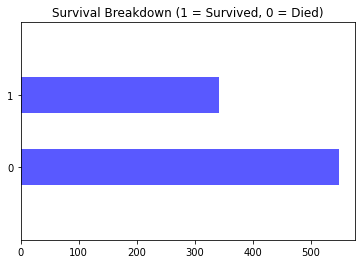

In [16]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
df.Survived.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(df.Survived.value_counts())) 
plt.title("Survival Breakdown (1 = Survived, 0 = Died)")

(-1.0, 2.0)

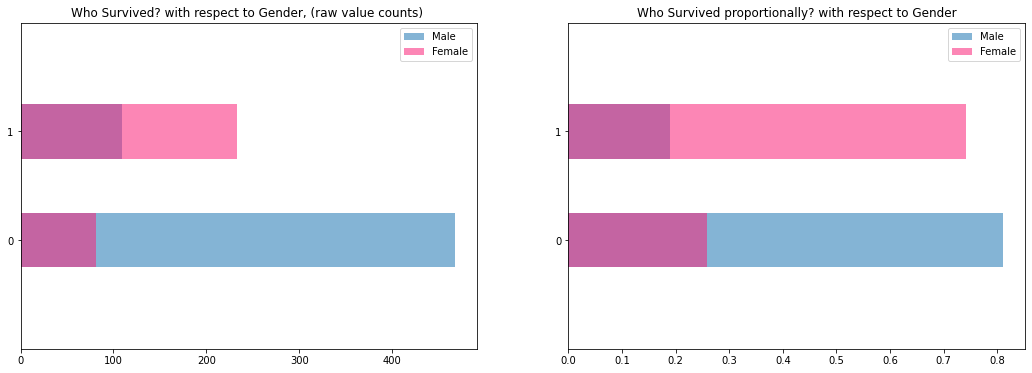

In [17]:
fig = plt.figure(figsize=(18,6))

#create a plot of two subsets, male and female, of the survived variable.
#After we do that we call value_counts() so it can be easily plotted as a bar graph. 
#'barh' is just a horizontal bar graph
df_male = df.Survived[df.Sex == 'male'].value_counts().sort_index()
df_female = df.Survived[df.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
df_male.plot(kind='barh',label='Male', alpha=0.55)
df_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
ax1.set_ylim(-1, 2) 

#adjust graph to display the proportions of survival by gender
ax2 = fig.add_subplot(122)
(df_male/float(df_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(df_female/float(df_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')

ax2.set_ylim(-1, 2)


In [18]:
fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

# building on the previous code, here we create an additional subset with in the gender subset 
# we created for the survived variable. I know, thats a lot of subsets. After we do that we call 
# value_counts() so it it can be easily plotted as a bar graph. this is repeated for each gender 
# class pair.
ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female, highclass', color='#FA2479', alpha=alpha_level)
ax1.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=alpha_level)
ax2.set_xticklabels(["Died","Survived"], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=alpha_level)
ax3.set_xticklabels(["Died","Survived"], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male, highclass', alpha=alpha_level, color='steelblue')
ax4.set_xticklabels(["Died","Survived"], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')


In [19]:
fig = plt.figure(figsize=(18,12), dpi=1600)
a = 0.65
# Step 1
ax1 = fig.add_subplot(341)
df.Survived.value_counts().plot(kind='bar', color="blue", alpha=a)
ax1.set_xlim(-1, len(df.Survived.value_counts()))
plt.title("Step. 1")

# Step 2
ax2 = fig.add_subplot(345)
df.Survived[df.Sex == 'male'].value_counts().plot(kind='bar',label='Male')
df.Survived[df.Sex == 'female'].value_counts().plot(kind='bar', color='#FA2379',label='Female')
ax2.set_xlim(-1, 2)
plt.title("Step. 2 \nWho Survived? with respect to Gender."); plt.legend(loc='best')

ax3 = fig.add_subplot(346)
(df.Survived[df.Sex == 'male'].value_counts()/float(df.Sex[df.Sex == 'male'].size)).plot(kind='bar',label='Male')
(df.Survived[df.Sex == 'female'].value_counts()/float(df.Sex[df.Sex == 'female'].size)).plot(kind='bar', color='#FA2379',label='Female')
ax3.set_xlim(-1,2)
plt.title("Who Survied proportionally?"); plt.legend(loc='best')


# Step 3
ax4 = fig.add_subplot(349)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female highclass', color='#FA2479', alpha=a)
ax4.set_xticklabels(["Survived", "Died"], rotation=0)
ax4.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax5 = fig.add_subplot(3,4,10, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=a)
ax5.set_xticklabels(["Died","Survived"], rotation=0)
ax5.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax6 = fig.add_subplot(3,4,11, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=a)
ax6.set_xticklabels(["Died","Survived"], rotation=0)
ax6.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax7 = fig.add_subplot(3,4,12, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male highclass', alpha=a, color='steelblue')
ax7.set_xticklabels(["Died","Survived"], rotation=0)
ax7.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')
